# Make PSD

In [1]:
include("../iLQR.jl")

iLQR

In [31]:
using iLQR
using Base.Test
using BenchmarkTools
using Plots

## Test Dynamics

In [ ]:
n,m = 3,2
A = [0 1 0; 0 0 1; 0 0 0]
B = [0 0; 0 1; 1 1]
x = [1;2;3]
u = [4;5]

Qf = diagm([10, 20, 30])
R = eye(m)*2
Q = diagm([3, 2, 1])

## Functions

In [4]:
function makePSD_current(A)
    n = size(A,1)
    mu = 0
    for i = 1:100
        if any(eigvals(A).<0.)
            mu += 1
            A += mu*eye(n)
        else
            break;
        end
    end
    return A
end

function makePSD_eig(A)
    δ = 1e-3
    λ,Q = eig(A)
    λ[λ .< δ] = δ
    Q*diagm(λ)Q'
end

function makePSD_cur_mod(A,δ=1.)
    n = size(A,1)
    mu = 0
    for i = 1:100
        if ~isposdef(A)
            mu += δ
            A += mu*eye(n)
        else
            break;
        end
    end
    return A
end

function makePSD_33(A)
    n = size(A,1)
    I = eye(n)

    β = 1e-3
    min_diag = minimum(diag(A))
    if min_diag > 0
        constraint_decrease_ratio = 0
    else
        constraint_decrease_ratio = -min_diag + β
    end
    
    for k = 1:100
        v = eigvals(A)
        if isposdef(A+constraint_decrease_ratio*I)
#             println("iter: $k")
            return A+constraint_decrease_ratio*I
        else
            constraint_decrease_ratio = max(2*constraint_decrease_ratio,β)
        end
    end
    return A
end

function makePSD_33_mod(A)
    n = size(A,1)
    I = eye(n)
    mu = 0
    
    β = 1e-2
    min_diag = minimum(diag(A))
    if min_diag > 0
        mu = 0
        δ = 1
    else
        mu = -min_diag + β
        δ = -min_diag
    end
    A += mu*I
    min_diag = abs(min_diag)
    
    for k = 1:100
        if ~isposdef(A)
            mu += δ
            A += mu*I
        else
#             println("iter: $k")
            break;
        end
    end
    return A
end

function makePSD_chol(A::Array)
    n = size(A,1)
    d = zeros(n)
    C = zeros(A)
    L = eye(A)
    β = 1e-3
    δ = 1e-3
    for j = 1:n
        t = 0
        for s = 1:j-1
            t += d[s]*L[j,s]^2
        end
        C[j,j] = A[j,j] - t
#         d[j] = cjj
        θ = maximum(C[j:n,j])
        d[j] = max(abs(C[j,j]),(θ\β)^2,δ)
        
        for i = j+1:n
            t = 0
            for s = 1:j-1
                t += d[s]*L[i,s]*L[j,s]
            end
            C[i,j] = A[i,j] - t
            L[i,j] = C[i,j] / d[j]
        end
    end
    D = diagm(d)
    return L,D
end

makePSD_chol (generic function with 1 method)

## Create Symmetric (non PSD) Matrix

In [5]:
n = 10
A = randn(n,n)
A = A'A-1
isposdef(A)

false

In [8]:
A1 = makePSD_current(A); println(norm(A1-A))
A2 = makePSD_cur_mod(A); println(norm(A2-A))
A3 = makePSD_33(A); println(norm(A3-A))
A4 = makePSD_33_mod(A); println(norm(A4-A))
@test isposdef(A1)
@test isposdef(A2)
@test isposdef(A3)
@test isposdef(A4)

6.000000000000002
6.000000000000002
8.192000000000002
6.000000000000002


Test Passed

LoadError: [91mUndefVarError: @btime not defined[39m

## Timing Tests

In [11]:
@btime makePSD_cur_mod(A)
@btime makePSD_33_mod(A)

  3.745 μs (29 allocations: 11.69 KiB)
  4.026 μs (24 allocations: 11.78 KiB)


10×10 Array{Float64,2}:
 17.3037     0.187935   -0.930121   …   1.28372  -1.91581    -4.60172 
  0.187935  19.3448      1.40536       -3.08864  -3.2367     -1.7733  
 -0.930121   1.40536    17.6842        -8.05624  -0.0587832  -0.373924
  0.735326  -5.38276    -0.643955      -2.54875   0.671312   -3.38484 
 -7.22286   -1.69571    -5.34609        3.95583  -0.96827    -1.32153 
 -3.97363   -2.70317    -4.53474    …   2.62932   0.555115   -1.54464 
 -3.24262    0.0521949   0.699046       2.09351   1.38237    -1.95622 
  1.28372   -3.08864    -8.05624       15.413    -4.69973    -3.73858 
 -1.91581   -3.2367     -0.0587832     -4.69973  11.1123      1.70968 
 -4.60172   -1.7733     -0.373924      -3.73858   1.70968     8.46663 

### Test PSD Matrix

In [12]:
n = 10
A = randn(n,n)
A = A'A
isposdef(A)

true

In [13]:
@btime makePSD_cur_mod(A)
@btime makePSD_33_mod(A)

  707.199 ns (3 allocations: 944 bytes)
  1.254 μs (9 allocations: 3.77 KiB)


10×10 Array{Float64,2}:
  9.58178    -4.10342   -1.56798   …   4.4951    11.0001    -0.885739
 -4.10342    18.476     -2.77111       1.36717    0.591129   6.12655 
 -1.56798    -2.77111    9.15291       1.10503    2.49907   -3.40365 
 -2.6129      5.03195   -0.170133      4.73274   -2.42702   -0.124012
  0.0528265  -0.229719  -3.70785       0.667241  -0.117513   0.540832
 -1.55059    -1.13266   -1.74145   …  -6.39981   -9.10601    1.30898 
  0.137167    2.74969   -2.83629      -0.988845  -6.81938    2.78984 
  4.4951      1.36717    1.10503      10.4121    11.6939    -0.599723
 11.0001      0.591129   2.49907      11.6939    24.0052    -1.25792 
 -0.885739    6.12655   -3.40365      -0.599723  -1.25792    5.1453  

In [34]:
N = 2.^(0:10)
T = zeros(length(N))
for (i,n) in enumerate(N)
    A = randn(n,n)
    A = A'A - 1
    t = @elapsed makePSD_cur_mod(A)
    T[i] = t
    println("n: $n, time=$t")
end

n: 1, time=3.984e-6
n: 2, time=2.4903e-5
n: 4, time=5.761e-6
n: 8, time=1.4838e-5
n: 16, time=5.2798e-5
n: 32, time=0.000214132
n: 64, time=0.006982906
n: 128, time=0.01341747
n: 256, time=0.018245619
n: 512, time=0.113145209
n: 1024, time=1.151988449


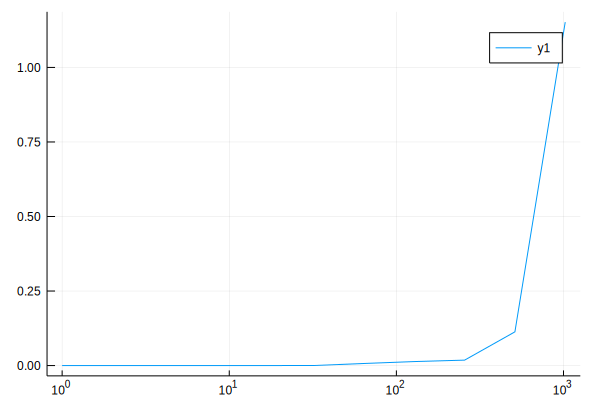

In [37]:
plot(N,T,xscale=:log10)